# Linking & Exploring Geo-Data

In this practical we're going to expand our understanding of how to use PySAL and GeoPandas as part of an analysis, and of how to implement different types of spatial and non-spatial joins in Python using the tools to-hand.

You'll notice that the number of libraries that we need to do our work is expanding -- gone are the days of just importing Seaborn and Pandas!

In [60]:
import os
import shapely
import zipfile
import numpy as np
import pysal as ps
import pandas as pd
import geopandas as gpd
import seaborn as sns
from shapely.geometry import Point
from pysal.contrib.viz import mapping as maps # For maps.plot_choropleth

import random 
random.seed(123456789) # For reproducibility

# Make numeric display a bit easier
pd.set_option('display.float_format', lambda x: '{:,.0f}'.format(x))

# Make sure output is into notebook
%matplotlib inline

## Loading the Data

Let's start by (re)loading both the AirBnB and the LSOA data, together with the NS-SeC data from last term! This will give us the tools with which to test our understanding of data linking _and_ allow us to do some simple, but hopefully interesting, analyses.

### Loading AirBnB Data

Here is all the code to load the AirBnB data into a GeoDataFrame called `sdf` (spatial sample  dataframe):

In [8]:
df       = pd.read_csv(os.path.join('data','airbnb-2016-Feb','listings-summary.csv.gz'))
sample   = df.sample(frac=0.1)
geometry = [Point(xy) for xy in zip(sample.longitude, sample.latitude)]
crs      = {'init' :'epsg:4326'}
sdf      = gpd.GeoDataFrame(sample, crs=crs, geometry=geometry)
sdf      = sdf.to_crs({'init' :'epsg:27700'})
sdf.head(3)[['id','host_id','neighbourhood','price','geometry']]

,id,host_id,neighbourhood,price,geometry
4510,1936018,10017430,Lambeth,32,POINT (530823.6063957848 173517.303804312)
4409,10476003,15218562,Lambeth,40,POINT (531241.3997858076 179049.41922119)
5501,6160637,225097,Lambeth,82,POINT (530567.7619375458 174537.2885375469)


### Loading the LSOA Shapefile

Here is all of the code to load the LDN-LSOA shapefile (note the switch to the `pdio` code so that we have a geopandas data frame to work with!):

In [67]:
lsoas = gpd.read_file(os.path.join('shapes','LDN-LSOAs.shp'))
lsoas.head(3)

,LSOA11CD,LSOA11NM,LSOA11NMW,geometry
0,E01000001,City of London 001A,City of London 001A,"POLYGON ((532105.0919998939 182011.23, 532162...."
1,E01000002,City of London 001B,City of London 001B,"POLYGON ((532746.8130000263 181786.891000028, ..."
2,E01000003,City of London 001C,City of London 001C,"POLYGON ((532135.1449999654 182198.1190000199,..."


### Loading the NS-SeC Data

Let's pull together everything we learned last term about what data we need to keep from the NS-SeC data file with everything we learned _this_ term with how to load data directly from a Zip file without the need to unzip it! 

Also, when you get to the end of this code block take a look at the first three columns and see if there's anything that look like it might match what we have in the `lsoas` geo-data.

In [34]:
z = zipfile.ZipFile(os.path.join('data','NSSHRP_UNIT_URESPOP.zip'))

nssec = pd.read_csv(z.open('Data_NSSHRP_UNIT_URESPOP.csv'), skiprows=[1])
del nssec['Unnamed: 15'] # If you have this column, this deletes it
del nssec['GEO_TYPE']
del nssec['GEO_TYP2']

colnames = ['CDU','GeoCode','GeoLabel','Total']
for i in range(1,9):
    colnames.append('Group' + str(i))
colnames.append('NC')
nssec.columns = colnames
    
nssec.head(3)

,CDU,GeoCode,GeoLabel,Total,Group1,Group2,Group3,Group4,Group5,Group6,Group7,Group8,NC
0,18373,95AA01S1,Aldergrove_1,982,98,464,234,35,80,39,25,0,nan
1,18374,95AA01S2,Aldergrove_2,1814,256,417,170,446,162,156,156,47,nan
2,18375,95AA01S3,Aldergrove_3,1494,226,399,176,294,86,114,159,30,nan


## Joining Data by Key

This is the most common way to join data (spatial or not) together: we have a unique id in one dataset and we match it to the _same_ unique id in a different data set. Remember that we have several types of join to choose from:

1. Inner join: this will keep only the rows that have matching unique ids in both data sets, so any unique id that doesn't match will be discarded.
2. Outer join: this will keep all rows in both data sets, regardless of whether or not there is a match in the other data set.
3. Left join: all rows in the 'left' data set will be kept, regardless of whether or not there is a match in the 'right' data set.
4. Right join: reverse of a left join.

Left and right joins are a matter of preference: there is no real difference between them, it just depends on which data set you think of as being 'first' (i.e. to the _left_ in the join).

There is, unfortunately, one bit of ugliness that we have to grapple with and it ties back to ideas of inheritance: `merge` is a _pandas_ function and pandas doesn't know about _geopandas_. So if we naively use pandas' merge function on a spatial data set then we get back a pandas dataframe. If, instead, we use the geopandas dataframe then we'll get back a geopandas dataframe. Again, this is a question of judgement -- the pandas `merge` is a little easier to read and gives us some more flexiblity, but with more hoops to jump through aftwards... Use whichever makes the most sense to you.

#### Method 1: Merge & Convert Back to Geopandas

There's also a tricky step in this approach because geopandas doesn't know how to read PySAL polygon objects so we have to convert _them_ into Shapely geometries as well!

In [73]:
# Step 1: Do the merge
merged_df = pd.merge(lsoas, nssec, left_on='LSOA11CD', right_on='GeoCode', how='left')
print("Merged df is of type: " + str(type(mergeddf)))

# Step 2: Create the geopandas GeoDataFrame explicitly -- 
# note that extra parameter called 'geometry' when creating a
# new geopandas df from scratch.
shpdf = gpd.GeoDataFrame(mergeddf, crs=crs, geometry=merged_df.geometry)
print("Shape df is of type: " + str(type(shpdf)))

Merged df is of type: <class 'pandas.core.frame.DataFrame'>
Shape df is of type: <class 'geopandas.geodataframe.GeoDataFrame'>


#### Method 2: Use Geopandas' Merge

This method is more direct, but it's not necessarily immediately clear what's going on because now `lsoas` is _implicitly_ the _left_ part of the join, not _explicitly_. Plus, if you were to reverse the order (so: `nssec.merge(lsoas...)`) then the result would no longer be a GeoDataFrame because you'd be using pandas' merge function, not geopandas'! Confusing, right?

In [75]:
shpdf = lsoas.merge(nssec, left_on='LSOA11CD', right_on='GeoCode')
print("Shape df is of type: " + str(type(shpdf)))

Shape df is of type: <class 'geopandas.geodataframe.GeoDataFrame'>


In [76]:
print("lsoas has {0} rows, {1} columns".format(lsoas.shape[0], lsoas.shape[1]))
print("nssec has {0} rows, {1} columns".format(nssec.shape[0], nssec.shape[1]))
print("shpdf has {0} rows, {1} columns".format(shpdf.shape[0], shpdf.shape[1]))
shpdf.head(3)

lsoas has 4835 rows, 4 columns
nssec has 42619 rows, 13 columns
shpdf has 4835 rows, 17 columns


,LSOA11CD,LSOA11NM,LSOA11NMW,geometry,CDU,GeoCode,GeoLabel,Total,Group1,Group2,Group3,Group4,Group5,Group6,Group7,Group8,NC
0,E01000001,City of London 001A,City of London 001A,"POLYGON ((532105.0919998939 182011.23, 532162....",19263,E01000001,City of London 001A,1465,687,511,90,94,17,13,7,10,36
1,E01000002,City of London 001B,City of London 001B,"POLYGON ((532746.8130000263 181786.891000028, ...",19264,E01000002,City of London 001B,1436,687,477,81,118,17,23,9,10,14
2,E01000003,City of London 001C,City of London 001C,"POLYGON ((532135.1449999654 182198.1190000199,...",19265,E01000003,City of London 001C,1250,333,394,142,89,59,89,60,49,35


It's worth taking a few minutes to review what that one line of code just did and _why_ I chose to do it that way:

* First, note that I _could_ have joined on `LSOA11NM` and `GeoLabel` instead of `LSOA11CD` and `GeoCode` -- the result would have been the same in this case, but as a _general rule_ you will usually get better results matching on something that has been _designed_ to be a key (as the 'Code' value has been here) than on regular text. Think of this way: there are many different 'entities' that might be called 'London' in a data set (there's the City of London, the Greater London Authority, Inner London, etc.), whereas there is probably only going to be _one_ E010000001.
* Second, why did I chose a left join when I just said that there's no real difference between left and right joins? In addition to what I wrote above about the potential confusion between pandas' merge function and geopandas' merge function, you also need to remember that `lsoas` contains the LSOAs that I can _map_, so there's not much point in keeping LSOAs that I can't actually map right? The NS-SeC data contains _every_ LSOA in England and Wales, so we don't really need those to be part of our analysis. If we had picked an _inner_ join instead then we'd have had a similar result _but_ we wouldn't have any way of knowing if we had lost data! If we have rows with _None_ values for any of the NS-SeC data then we know that we have a small problem thanks to the use of the left join.
* Finally, if this whole matter of joins is a bit confusing, I'd suggest playing with the _how_ parameter in the code block above to see how it changes the 'diagnostics' that I print out.

### Better Maps

We're now going to look at a slightly better way of creating maps -- we'll have less control over the output but we will at least get a legend this time! At this point we're heading towards the limits of what we can teach you without writing even longer notebooks. To really get to grips with how to create _good_ looking maps using code you'll have to familiarise yourself with `matplotlib` and you will also need to write your own legend function to customise placement and such. But it's both important _and_ useful to know that you could easily generate 20 maps _this_ way and they would be broadly acceptable for an IGS without even having to open up QGIS or Arc!

This approach uses a `plot_choropleth` function provided by PySAL. So now let's go ahead and calculate a Location Quotient for Group 1 _and_ map it using a variety of styles so that we can see how our understanding of the data changes with the different classification schemes -- we did this in Practical 2 as well, but it should be more clear here (**_Note_**: this may take some time to finish):

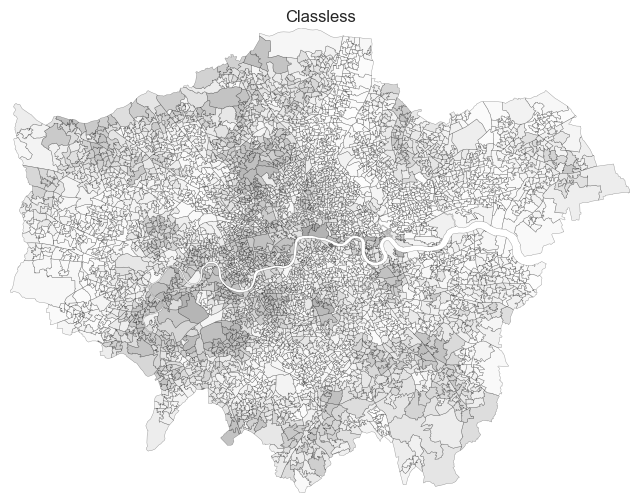

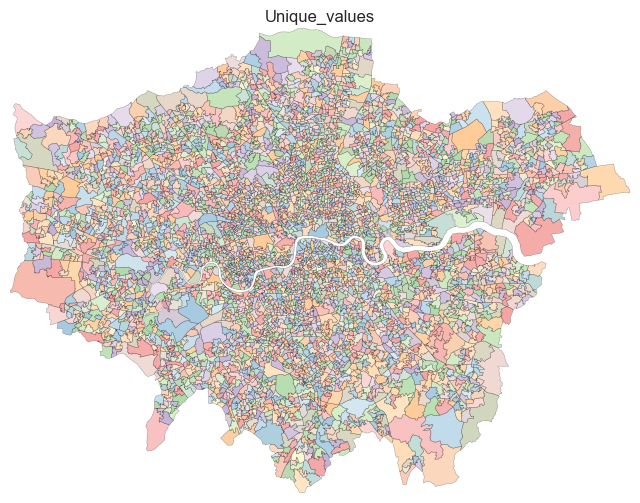

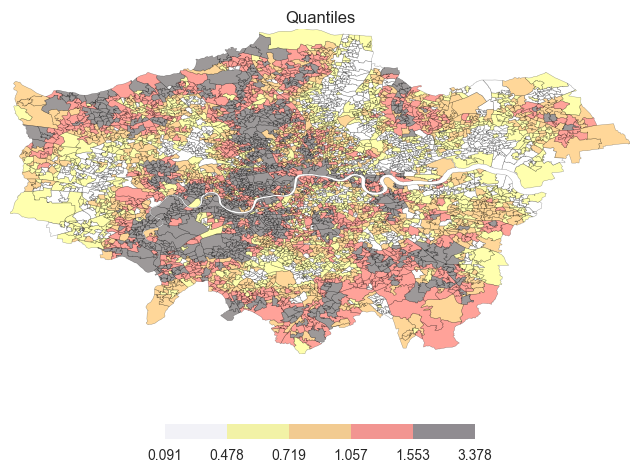

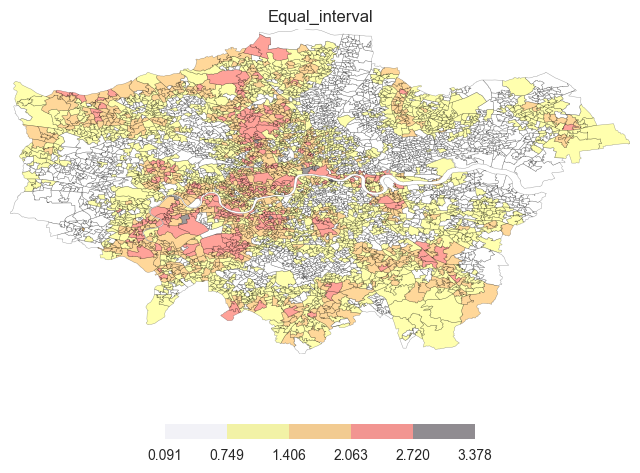

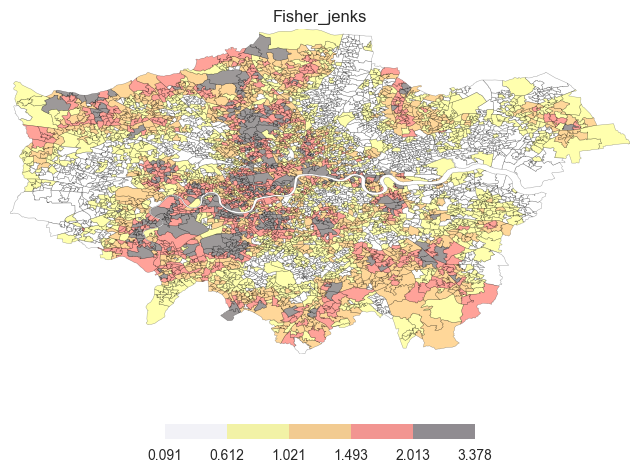

In [119]:
shpdf['Group1Lq'] = (
    shpdf.Group1.values / shpdf.Total.astype(float).values) / (float(shpdf.Group1.sum()) / shpdf.Total.sum()
)

shp_link = os.path.join('shapes','LDN-LSOAs.shp')
shpdf.to_file(shp_link)
values = np.array(ps.open(shp_link.replace('.shp','.dbf')).by_col('Group1Lq'))

types = ['classless', 'unique_values', 'quantiles', 'equal_interval', 'fisher_jenks']
for typ in types:
    maps.plot_choropleth(shp_link, values, typ, title=typ.capitalize(), figsize=(8,6))